### SMOTE: Synthetic Minority Over-sampling Technique
[Link to the paper](https://arxiv.org/abs/1106.1813)

SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line.

Specifically, a random example from the minority class is first chosen. Then k of the nearest neighbors for that example are found (typically k=5). A randomly selected neighbor is chosen and a synthetic example is created at a randomly selected point between the two examples in feature space [[source]](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/)

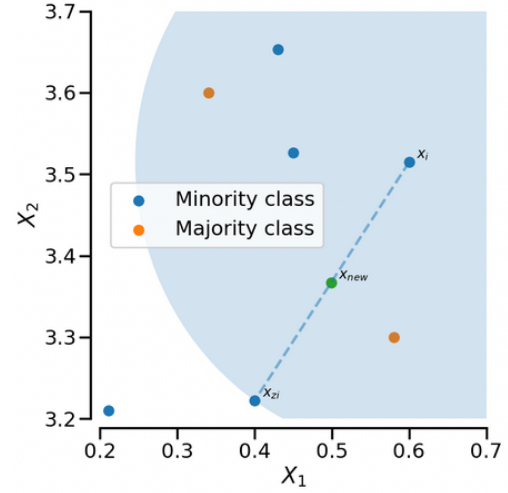

In [1]:
!pip install imbalanced-learn


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import imblearn
print(imblearn.__version__)

from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

0.10.1


In [ ]:
# # getting the cleaned data from the personal Google Drive
# # !gdown '1bFPcr699XpzMVG45T9xlv4rIaan74_Ch' -O train_imbalanced.csv
# !gdown '1ICZUG9vdJKSWjS1Ojr_Vb3VKgONeTXX1' -O train_imbalanced_85.csv
# !gdown '1F1mHLwlno3OOtpSpMsiQqhoow6aj__DN' -O test_imbalanced_15.csv

In [4]:
# train = pd.read_csv('train_imbalanced.csv') # 207 features
# train = pd.read_csv('train_imbalanced_85.csv') # 22 features Colab
train = pd.read_csv('../data/train_imbalanced_85.csv') # 22 features Local

# test = pd.read_csv('test_imbalanced_15.csv') # Colab
test = pd.read_csv('../data/test_imbalanced_15.csv') # Local
train.shape, test.shape

((2158774, 23), (380961, 23))

### Data for binary Classification
#### Undersample the majority class for binary case (training set)

In [6]:
train.head()

,sport,dsport,dur,sbytes,dbytes,sttl,dttl,sload,spkts,stcpb,...,res_bdy_len,sjit,djit,sintpkt,dintpkt,tcprtt,ct_srv_src,ct_src_ltm,ct_dst_sport_ltm,attack_cat_code
0,1043,53,0.000005,264,0,60,0,211200000.0,2,0,...,0,0.000000,0.000000,0.005000,0.000000,0.000000,23,23,23,0
1,47439,53,0.000006,114,0,254,0,76000000.0,2,0,...,0,0.000000,0.000000,0.006000,0.000000,0.000000,51,40,18,1
2,54472,53,0.001060,146,178,31,29,550943.4,2,0,...,0,0.000000,0.000000,0.010000,0.006000,0.000000,4,5,1,0
3,1043,53,0.000007,114,0,254,0,65142856.0,2,0,...,0,0.000000,0.000000,0.007000,0.000000,0.000000,25,25,25,1
4,62795,5190,0.006134,1920,4312,31,29,2390609.8,22,3198205079,...,0,17.042793,13.784042,0.275381,0.238696,0.000808,5,3,1,0


In [7]:
test.head()

,sport,dsport,dur,sbytes,dbytes,sttl,dttl,sload,spkts,stcpb,...,res_bdy_len,sjit,djit,sintpkt,dintpkt,tcprtt,ct_srv_src,ct_src_ltm,ct_dst_sport_ltm,attack_cat_code
0,37262,80,12.950944,17850,1087890,31,29,1.099348e+04,334,1379677982,...,524288,2593.6565,1605.01660,38.890810,17.382517,0.001079,2,3,1,0
1,42283,53,0.001049,130,162,31,29,4.957102e+05,2,0,...,0,0.0000,0.00000,0.010000,0.007000,0.000000,3,2,1,0
2,3449,47598,0.100816,3614,49590,31,29,2.820188e+05,60,2105411413,...,0,0.0000,88.56262,1.703288,1.643164,0.000740,10,2,1,0
3,1043,53,0.000005,264,0,60,0,2.112000e+08,2,0,...,0,0.0000,0.00000,0.005000,0.000000,0.000000,30,23,23,0
4,48475,25683,0.243382,424,8824,31,29,1.219482e+04,8,2104658990,...,0,2236.4290,1778.51710,34.722140,22.076637,0.000668,3,5,1,0


In [8]:
# get the labels
codes = {'Normal':0,
         'Generic':1,
         'Exploits':2,
         'Fuzzers': 3,
         'DoS':4,
         'Reconnaissance':5,
         'Analysis':6,
         'Backdoor':7,
         'Shellcode':8,
         'Worms':9   
}
labels = [x for x in codes.keys()]
# labels

# reversing the codes
reverse_codes  = dict((v,k) for k,v in codes.items())

train['attack_cat'] = train['attack_cat_code'].map(reverse_codes)
# data['attack_cat'].value_counts()

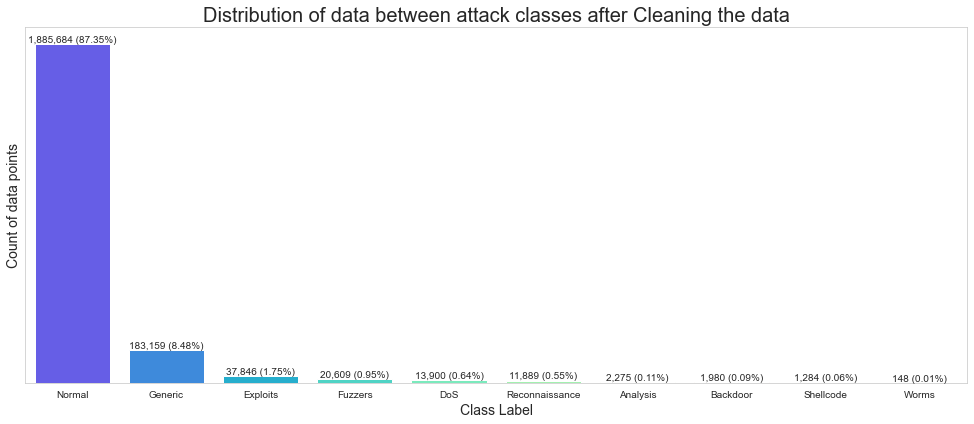

In [9]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(14,6))

ax = sns.countplot(
    data=train,
    x = "attack_cat",
    palette='rainbow',
    order = train["attack_cat"].value_counts().index)


        
abs_values = train["attack_cat"].value_counts(ascending=False)
rel_values = train["attack_cat"].value_counts(ascending=False, normalize=True).values * 100
lbls = [f'{p[0]:,} ({p[1]:.2f}%)' for p in zip(abs_values, rel_values)]

ax.bar_label(container=ax.containers[0], labels=lbls)#, fontsize = 14)

ax.set_xlabel('Class Label', fontsize = 14)
ax.set_ylabel('Count of data points', fontsize = 14)
ax.set_title('Distribution of data between attack classes after Cleaning the data', fontsize = 20)
plt.tight_layout()
# plt.ylim((0,250000))
plt.yticks([]) 
plt.show()



In [10]:
# mapping attack classes to binary case
train['label'] = train['attack_cat_code'].apply(lambda x: 0 if x==0 else 1)
train[['label', 'attack_cat_code']].value_counts()

label  attack_cat_code
0      0                  1885684
1      1                   183159
       2                    37846
       3                    20609
       4                    13900
       5                    11889
       6                     2275
       7                     1980
       8                     1284
       9                      148
dtype: int64

In [17]:
train['label'].value_counts()

0    1996606
1     289155
Name: label, dtype: int64

In [11]:
# removing labels from the train set
X_bin = train.drop(['label', 'attack_cat_code'], axis=1)

# creating a dataframe for the target
y_bin = train['label']
X_bin.shape, y_bin.shape

((2158774, 23), (2158774,))

In [12]:
# https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html
# Undersample the majority class
rus = RandomUnderSampler(random_state=0, 
                         sampling_strategy = 'majority',
                         replacement = False)
X_bin, y_bin = rus.fit_resample(X_bin, y_bin)
print(sorted(Counter(y_bin).items()))

[(0, 273090), (1, 273090)]


In [13]:
# merging binary classification data into one dataframe
train_bin = pd.concat([X_bin, y_bin], axis = 1)
# checking the result
train_bin.label.value_counts()

0    273090
1    273090
Name: label, dtype: int64

In [14]:
reverse_codes_bin = {0: 'Normal',
                     1: 'Attack'}

# mapping binary attack codes to categories`
train_bin['attack_cat'] = train_bin['label'].map(reverse_codes_bin)
train_bin['attack_cat'].value_counts()

Normal    273090
Attack    273090
Name: attack_cat, dtype: int64

In [15]:
train_bin.head()

,sport,dsport,dur,sbytes,dbytes,sttl,dttl,sload,spkts,stcpb,...,sjit,djit,sintpkt,dintpkt,tcprtt,ct_srv_src,ct_src_ltm,ct_dst_sport_ltm,attack_cat,label
0,1043,53,0.000006,264,0,60,0,1.760000e+08,2,0,...,0.000000,0.000000,0.006000,0.000000,0.000000,25,25,13,Normal,0
1,49459,50626,0.028047,3390,44988,31,29,9.498342e+05,56,2353430619,...,30.914173,29.677431,0.512981,0.481158,0.000742,2,2,1,Normal,0
2,54264,53,0.001079,146,178,31,29,5.412419e+05,2,0,...,0.000000,0.000000,0.009000,0.008000,0.000000,2,6,1,Normal,0
3,52762,25,1.102414,37308,3172,31,29,2.655336e+05,52,3780377668,...,1786.695700,59.592686,21.608590,29.782433,0.000585,2,2,1,Normal,0
4,7514,80,1.147243,18890,1087890,31,29,1.313549e+05,354,4147615496,...,192.641300,115.099230,3.249096,1.539207,0.000649,1,2,1,Normal,0


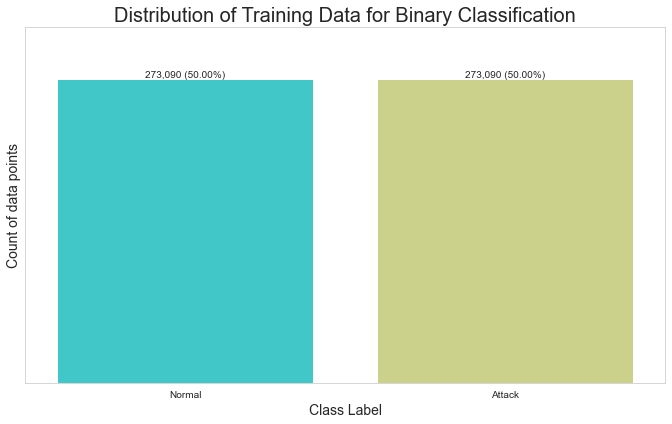

In [16]:
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.countplot(
    data=train_bin,
    x = "attack_cat",
    palette='rainbow',
    order = train_bin["attack_cat"].value_counts().index)


        
abs_values = train_bin["attack_cat"].value_counts(ascending=False)
rel_values = train_bin["attack_cat"].value_counts(ascending=False, normalize=True).values * 100
lbls = [f'{p[0]:,} ({p[1]:.2f}%)' for p in zip(abs_values, rel_values)]

ax.bar_label(container=ax.containers[0], labels=lbls)#, fontsize = 14)

ax.set_xlabel('Class Label', fontsize = 14)
ax.set_ylabel('Count of data points', fontsize = 14)
ax.set_title('Distribution of Training Data for Binary Classification', fontsize = 20)
plt.tight_layout()
plt.ylim((0,320000))
plt.yticks([]) 
plt.show()

In [17]:
# exporting the results
train_bin.to_csv('train_balanced_bin_22_features.csv', index = False)

In [ ]:
# from google.colab import files
# files.download('train_balanced_bin.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Test set for binary case

In [18]:
test.head()

,sport,dsport,dur,sbytes,dbytes,sttl,dttl,sload,spkts,stcpb,...,res_bdy_len,sjit,djit,sintpkt,dintpkt,tcprtt,ct_srv_src,ct_src_ltm,ct_dst_sport_ltm,attack_cat_code
0,37262,80,12.950944,17850,1087890,31,29,1.099348e+04,334,1379677982,...,524288,2593.6565,1605.01660,38.890810,17.382517,0.001079,2,3,1,0
1,42283,53,0.001049,130,162,31,29,4.957102e+05,2,0,...,0,0.0000,0.00000,0.010000,0.007000,0.000000,3,2,1,0
2,3449,47598,0.100816,3614,49590,31,29,2.820188e+05,60,2105411413,...,0,0.0000,88.56262,1.703288,1.643164,0.000740,10,2,1,0
3,1043,53,0.000005,264,0,60,0,2.112000e+08,2,0,...,0,0.0000,0.00000,0.005000,0.000000,0.000000,30,23,23,0
4,48475,25683,0.243382,424,8824,31,29,1.219482e+04,8,2104658990,...,0,2236.4290,1778.51710,34.722140,22.076637,0.000668,3,5,1,0


In [19]:
test.attack_cat_code.value_counts()

0    332768
1     32322
2      6679
3      3637
4      2453
5      2098
6       402
7       349
8       227
9        26
Name: attack_cat_code, dtype: int64

In [20]:
# mapping attack classes to binary case
test['label'] = test['attack_cat_code'].apply(lambda x: 0 if x==0 else 1)
test[['label', 'attack_cat_code']].value_counts()

label  attack_cat_code
0      0                  332768
1      1                   32322
       2                    6679
       3                    3637
       4                    2453
       5                    2098
       6                     402
       7                     349
       8                     227
       9                      26
dtype: int64

In [21]:
test['label'].value_counts()

0    332768
1     48193
Name: label, dtype: int64

In [22]:
# removing labels from the test set
X_bin = test.drop(['label', 'attack_cat_code'], axis=1)

# creating a dataframe for the target
y_bin = test['label']
X_bin.shape, y_bin.shape

((380961, 22), (380961,))

In [23]:
# https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html
# Undersample the majority class
rus = RandomUnderSampler(random_state=0, 
                         sampling_strategy = 'majority',
                         replacement = False)
X_bin, y_bin = rus.fit_resample(X_bin, y_bin)
print(sorted(Counter(y_bin).items()))

[(0, 48193), (1, 48193)]


In [24]:
# merging binary classification data into one dataframe
test_bin = pd.concat([X_bin, y_bin], axis = 1)
# checking the result
test_bin.label.value_counts()

0    48193
1    48193
Name: label, dtype: int64

In [25]:
# mapping binary attack codes to categories`
test_bin['attack_cat'] = test_bin['label'].map(reverse_codes_bin)
test_bin['attack_cat'].value_counts()

Normal    48193
Attack    48193
Name: attack_cat, dtype: int64

In [26]:
test_bin[['label', 'attack_cat']].value_counts()

label  attack_cat
0      Normal        48193
1      Attack        48193
dtype: int64

In [27]:
test_bin.head()

,sport,dsport,dur,sbytes,dbytes,sttl,dttl,sload,spkts,stcpb,...,sjit,djit,sintpkt,dintpkt,tcprtt,ct_srv_src,ct_src_ltm,ct_dst_sport_ltm,label,attack_cat
0,21459,63318,0.016364,2854,29182,31,29,1.364947e+06,46,3229994277,...,20.977210,20.363316,0.362545,0.361091,0.000585,4,5,1,0,Normal
1,1043,53,0.000007,264,0,60,0,1.508571e+08,2,0,...,0.000000,0.000000,0.007000,0.000000,0.000000,16,16,8,0,Normal
2,47636,6881,0.013123,1540,1644,31,29,8.802865e+05,16,2230321286,...,58.841938,1.350065,0.852533,0.744588,0.000580,9,5,1,0,Normal
3,55900,53,0.000991,146,178,31,29,5.893038e+05,2,0,...,0.000000,0.000000,0.004000,0.006000,0.000000,2,1,1,0,Normal
4,47439,53,0.000008,264,0,60,0,1.320000e+08,2,0,...,0.000000,0.000000,0.008000,0.000000,0.000000,32,32,12,0,Normal


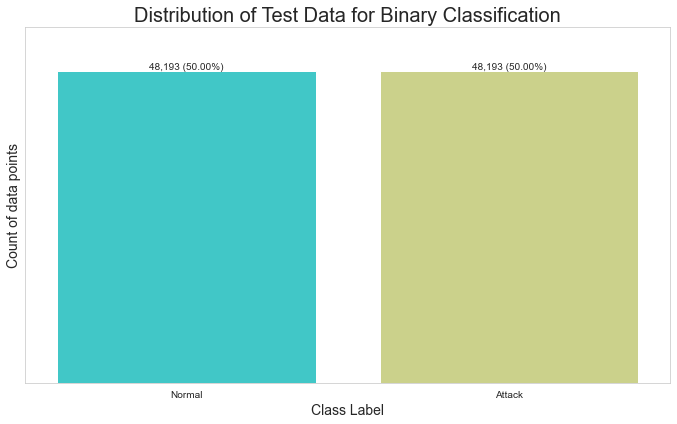

In [31]:
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.countplot(
    data=test_bin,
    x = "attack_cat",
    palette='rainbow',
    order = test_bin["attack_cat"].value_counts().index)


        
abs_values = test_bin["attack_cat"].value_counts(ascending=False)
rel_values = test_bin["attack_cat"].value_counts(ascending=False, normalize=True).values * 100
lbls = [f'{p[0]:,} ({p[1]:.2f}%)' for p in zip(abs_values, rel_values)]

ax.bar_label(container=ax.containers[0], labels=lbls)#, fontsize = 14)

ax.set_xlabel('Class Label', fontsize = 14)
ax.set_ylabel('Count of data points', fontsize = 14)
ax.set_title('Distribution of Test Data for Binary Classification', fontsize = 20)
plt.tight_layout()
plt.ylim((0,55000))
plt.yticks([]) 
plt.show()

In [32]:
# exporting the results
test_bin.to_csv('test_balanced_bin_22_features.csv', index = False)

#### SMOTE for oversampling the attack classes

In [33]:
# Getting the count of instances of each class
train['attack_cat_code'].value_counts()

0    1885684
1     183159
2      37846
3      20609
4      13900
5      11889
6       2275
7       1980
8       1284
9        148
Name: attack_cat_code, dtype: int64

In [51]:
# removing labels from the train set
X = train.drop(['attack_cat_code', 'label', 'attack_cat'], axis=1)

# creating a dataframe for the target
y = train['attack_cat_code']

In [52]:
X.shape, y.shape

((2158774, 22), (2158774,))

In [53]:
y.value_counts()

0    1885684
1     183159
2      37846
3      20609
4      13900
5      11889
6       2275
7       1980
8       1284
9        148
Name: attack_cat_code, dtype: int64

In [54]:
X.head()

,sport,dsport,dur,sbytes,dbytes,sttl,dttl,sload,spkts,stcpb,...,trans_depth,res_bdy_len,sjit,djit,sintpkt,dintpkt,tcprtt,ct_srv_src,ct_src_ltm,ct_dst_sport_ltm
0,1043,53,0.000005,264,0,60,0,211200000.0,2,0,...,0,0,0.000000,0.000000,0.005000,0.000000,0.000000,23,23,23
1,47439,53,0.000006,114,0,254,0,76000000.0,2,0,...,0,0,0.000000,0.000000,0.006000,0.000000,0.000000,51,40,18
2,54472,53,0.001060,146,178,31,29,550943.4,2,0,...,0,0,0.000000,0.000000,0.010000,0.006000,0.000000,4,5,1
3,1043,53,0.000007,114,0,254,0,65142856.0,2,0,...,0,0,0.000000,0.000000,0.007000,0.000000,0.000000,25,25,25
4,62795,5190,0.006134,1920,4312,31,29,2390609.8,22,3198205079,...,0,0,17.042793,13.784042,0.275381,0.238696,0.000808,5,3,1


In [55]:
 # get count of unique labels in the train set
unique, counts = np.unique(y, return_counts=True)
counts = dict(zip(unique, counts))
print(counts)

{0: 1885684, 1: 183159, 2: 37846, 3: 20609, 4: 13900, 5: 11889, 6: 2275, 7: 1980, 8: 1284, 9: 148}


In [56]:
counts[0], counts[1]

(1885684, 183159)

In [57]:
# setting the desired target ratio to upsample all attack classes to the highest
# number in the original data and keeping the normal class unchanged
target_ratio={0: counts[0], 
              1: counts[1], 
              2: counts[1], 
              3: counts[1], 
              4: counts[1], 
              5: counts[1], 
              6: counts[1], 
              7: counts[1], 
              8: counts[1], 
              9: counts[1]}

In [58]:
sm = SMOTE(random_state=42,
           sampling_strategy = target_ratio, 
           k_neighbors=5)

X_smote, y_smote = sm.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_smote))

Resampled dataset shape Counter({0: 1885684, 1: 183159, 2: 183159, 7: 183159, 8: 183159, 3: 183159, 6: 183159, 4: 183159, 5: 183159, 9: 183159})


In [59]:
# Undersample the majority class for multi-class case
rus = RandomUnderSampler(random_state=0, 
                         sampling_strategy = 'not minority',
                         replacement = False)

X_balanced, y_balanced = rus.fit_resample(X_smote, y_smote)
print(sorted(Counter(y_balanced).items()))

[(0, 183159), (1, 183159), (2, 183159), (3, 183159), (4, 183159), (5, 183159), (6, 183159), (7, 183159), (8, 183159), (9, 183159)]


In [66]:
# merging multi-class dataframes into one
train_balanced = pd.concat([X_balanced, y_balanced], axis=1)
# checking the result
train_balanced.attack_cat_code.value_counts()

0    183159
1    183159
2    183159
3    183159
4    183159
5    183159
6    183159
7    183159
8    183159
9    183159
Name: attack_cat_code, dtype: int64

In [67]:
train_balanced.head()

,sport,dsport,dur,sbytes,dbytes,sttl,dttl,sload,spkts,stcpb,...,res_bdy_len,sjit,djit,sintpkt,dintpkt,tcprtt,ct_srv_src,ct_src_ltm,ct_dst_sport_ltm,attack_cat_code
0,1043,53,0.000006,264,0,60,0,1.760000e+08,2,0,...,0,0.000000,0.000000,0.006000,0.000000,0.000000,25,25,13,0
1,49459,50626,0.028047,3390,44988,31,29,9.498342e+05,56,2353430619,...,0,30.914173,29.677431,0.512981,0.481158,0.000742,2,2,1,0
2,54264,53,0.001079,146,178,31,29,5.412419e+05,2,0,...,0,0.000000,0.000000,0.009000,0.008000,0.000000,2,6,1,0
3,52762,25,1.102414,37308,3172,31,29,2.655336e+05,52,3780377668,...,0,1786.695700,59.592686,21.608590,29.782433,0.000585,2,2,1,0
4,7514,80,1.147243,18890,1087890,31,29,1.313549e+05,354,4147615496,...,524288,192.641300,115.099230,3.249096,1.539207,0.000649,1,2,1,0


In [62]:
# exporting the result
train_balanced.to_csv('train_balanced_85_multi_22_features.csv', index = False)

In [ ]:
# downloading the result from colab
files.download('train_balanced.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [65]:
train_balanced["attack_cat"].value_counts()

Normal            1599809
Generic            155567
Exploits            31984
Fuzzers             17558
DoS                 11808
Reconnaissance      10082
Analysis             1909
Backdoor             1668
Shellcode            1082
Worms                 123
Name: attack_cat, dtype: int64

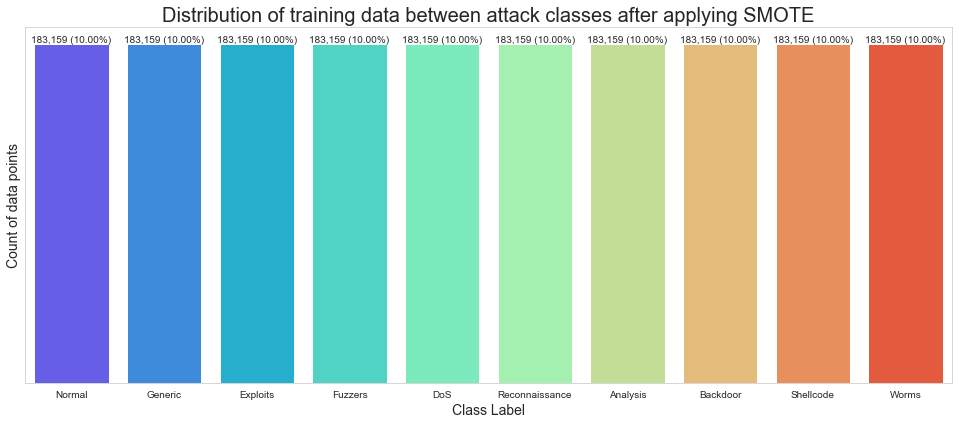

In [68]:
# map back names of the classes
train_balanced['attack_cat'] = train_balanced['attack_cat_code'].map(reverse_codes)

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(14,6))

ax = sns.countplot(
    data=train_balanced,
    x = "attack_cat",
    palette='rainbow',
    order = train_balanced["attack_cat"].value_counts().index)


        
abs_values = train_balanced["attack_cat"].value_counts(ascending=False)
rel_values = train_balanced["attack_cat"].value_counts(ascending=False, normalize=True).values * 100
lbls = [f'{p[0]:,} ({p[1]:.2f}%)' for p in zip(abs_values, rel_values)]

ax.bar_label(container=ax.containers[0], labels=lbls)#, fontsize = 14)

ax.set_xlabel('Class Label', fontsize = 14)
ax.set_ylabel('Count of data points', fontsize = 14)
ax.set_title('Distribution of training data between attack classes after applying SMOTE', fontsize = 20)
plt.tight_layout()
# plt.ylim((0,250000))
plt.yticks([]) 
plt.show()
